# Predicting NBA Daily Fantasy Scores

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import pickle
import nba

First I will scrape every game log for every player from the 2017, 2018, and 2019 seasons.  This uses the nba.py script.  You will notice that these parts are commented out below to avoid re-scraping each time I work on this file.  Instead each year's stats have been loaded into a pickle file that can be loaded on command.

In [2]:
# links_2019 = nba.get_links(2019)

In [3]:
# raw_2019 = nba.get_all_stats(links_2019)

In [4]:
# with open('nba_2019.pickle','wb') as to_write:
#     pickle.dump(raw_2019,to_write)

In [5]:
with open('nba_2019.pickle','rb') as read_file:
    stats = pickle.load(read_file)

In [6]:
stats_2019 = pd.DataFrame(stats)

In [7]:
# links_2018 = nba.get_links(2018)
# raw_2018 = nba.get_all_stats(links_2018)

In [8]:
#with open('nba_2018.pickle','wb') as to_write:
 #   pickle.dump(raw_2018,to_write)

In [9]:
with open('nba_2018.pickle','rb') as read_file:
    raw_2018 = pickle.load(read_file)

stats_2018 = pd.DataFrame(raw_2018)

In [10]:
#links_2017 = nba.get_links(2017)
#raw_2017 = nba.get_all_stats(links_2017)

In [11]:
#with open('nba_2017.pickle','wb') as to_write:
 #   pickle.dump(raw_2017,to_write)

In [12]:
with open('nba_2017.pickle','rb') as read_file:
    raw_2017 = pickle.load(read_file)

stats_2017 = pd.DataFrame(raw_2017)

In [13]:
nba_stats = pd.concat([stats_2017,stats_2018,stats_2019])
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121058 entries, 0 to 41281
Data columns (total 31 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Player      121058 non-null  object
 1   Rank        121058 non-null  object
 2   Game        115569 non-null  object
 3   Date        115569 non-null  object
 4   Age         115569 non-null  object
 5   Team        115569 non-null  object
 6   Away        115569 non-null  object
 7   Opp         115569 non-null  object
 8   Result      115569 non-null  object
 9   Started     115569 non-null  object
 10  min_played  78345 non-null   object
 11  fgm         78345 non-null   object
 12  fga         78345 non-null   object
 13  fgp         78345 non-null   object
 14  3pm         78345 non-null   object
 15  3pa         78345 non-null   object
 16  3pp         78345 non-null   object
 17  ftm         78345 non-null   object
 18  fta         78345 non-null   object
 19  ftp         78345 non-nu

Find out what's going on with the null values.

In [14]:
nba_stats[nba_stats.pts.isnull()]

,Player,Rank,Game,Date,Age,Team,Away,Opp,Result,Started,...,drb,trb,ast,stl,blk,tov,pf,pts,GmSc,plus_minus
20,Sean Kilpatrick,Rk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Sean Kilpatrick,Rk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Sean Kilpatrick,42,,2017-01-20,27-014,BRK,@,NOP,W (+29),Did Not Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,Sean Kilpatrick,Rk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Sean Kilpatrick,67,,2017-03-16,27-069,BRK,@,NYK,W (+11),Inactive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41277,Tony Snell,79,,2019-04-04,27-145,MIL,@,PHI,W (+6),Did Not Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41278,Tony Snell,80,,2019-04-06,27-147,MIL,,BRK,L (-5),Did Not Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41279,Tony Snell,Rk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41280,Tony Snell,81,,2019-04-07,27-148,MIL,,ATL,W (+8),Did Not Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So it seems like all of the null values in the actual stats columns are a result of that player not playing in that given game.  Because there are zeroes, I'll go ahead and remove rows where any actual stat is null.

In [15]:
nba_stats.dropna(subset=['pts'],inplace=True)

In [16]:
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78345 entries, 0 to 41272
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Player      78345 non-null  object
 1   Rank        78345 non-null  object
 2   Game        78345 non-null  object
 3   Date        78345 non-null  object
 4   Age         78345 non-null  object
 5   Team        78345 non-null  object
 6   Away        78345 non-null  object
 7   Opp         78345 non-null  object
 8   Result      78345 non-null  object
 9   Started     78345 non-null  object
 10  min_played  78345 non-null  object
 11  fgm         78345 non-null  object
 12  fga         78345 non-null  object
 13  fgp         78345 non-null  object
 14  3pm         78345 non-null  object
 15  3pa         78345 non-null  object
 16  3pp         78345 non-null  object
 17  ftm         78345 non-null  object
 18  fta         78345 non-null  object
 19  ftp         78345 non-null  object
 20  orb   

Now we are golden.  All rows contain valid values for each column.  But everything is a string.  We need to clean this data into the approriate data types.

In [17]:
# convert data to appropriate data types rather than all strings

ints = ['Rank','Game','Started','fgm','fga','3pm','3pa','ftm','fta','orb','drb','trb','ast','stl','blk','tov','pf','pts']

nba_stats
for col in ints:
    try:
        nba_stats[col] = nba_stats[col].astype(int)
        print('Successfully converted: ',col)
    except:
        print('failed to convert:',col)

floats = ['fgp','3pp','ftp','GmSc']

for col in floats:
    try:
        nba_stats[col] = nba_stats[col].astype(float)
        print('Successfully converted:',col)
    except:
        print('Failed to convert:',col)

nba_stats['Date'] = pd.to_datetime(nba_stats.Date)

nba_stats['Away'] = nba_stats.Away.map({'@':1,' ':0,np.nan:0})

Successfully converted:  Rank
Successfully converted:  Game
Successfully converted:  Started
Successfully converted:  fgm
Successfully converted:  fga
Successfully converted:  3pm
Successfully converted:  3pa
Successfully converted:  ftm
Successfully converted:  fta
Successfully converted:  orb
Successfully converted:  drb
Successfully converted:  trb
Successfully converted:  ast
Successfully converted:  stl
Successfully converted:  blk
Successfully converted:  tov
Successfully converted:  pf
Successfully converted:  pts
Failed to convert: fgp
Failed to convert: 3pp
Failed to convert: ftp
Successfully converted: GmSc


In [18]:
nba_stats.dtypes

Player                object
Rank                   int64
Game                   int64
Date          datetime64[ns]
Age                   object
Team                  object
Away                 float64
Opp                   object
Result                object
Started                int64
min_played            object
fgm                    int64
fga                    int64
fgp                   object
3pm                    int64
3pa                    int64
3pp                   object
ftm                    int64
fta                    int64
ftp                   object
orb                    int64
drb                    int64
trb                    int64
ast                    int64
stl                    int64
blk                    int64
tov                    int64
pf                     int64
pts                    int64
GmSc                 float64
plus_minus            object
dtype: object

In [19]:
nba_stats[nba_stats.fgp==''][['fgp','fgm','fga']]

,fgp,fgm,fga
87,,0,0
89,,0,0
97,,0,0
105,,0,0
108,,0,0
...,...,...,...
40985,,0,0
41022,,0,0
41234,,0,0
41241,,0,0


Looks like when a player did not take any shots in a game, field goal percentage returns an empty string.

In [20]:
for col in ['fgp','3pp','ftp']:
    nba_stats.loc[nba_stats[col]=='',col] = 0
    nba_stats[col] = nba_stats[col].astype(float)

In [21]:
# eliminate columns that are not factored into daily fantasy scoring
# daily fantasy scoring is based on volume so percentages are irrelevant

nba_stats.drop(['Rank','Game','Age','Result','Started','fgp','3pp','ftp','pf','GmSc','plus_minus'],axis=1,inplace=True)
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78345 entries, 0 to 41272
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Player      78345 non-null  object        
 1   Date        78345 non-null  datetime64[ns]
 2   Team        78345 non-null  object        
 3   Away        39118 non-null  float64       
 4   Opp         78345 non-null  object        
 5   min_played  78345 non-null  object        
 6   fgm         78345 non-null  int64         
 7   fga         78345 non-null  int64         
 8   3pm         78345 non-null  int64         
 9   3pa         78345 non-null  int64         
 10  ftm         78345 non-null  int64         
 11  fta         78345 non-null  int64         
 12  orb         78345 non-null  int64         
 13  drb         78345 non-null  int64         
 14  trb         78345 non-null  int64         
 15  ast         78345 non-null  int64         
 16  stl         78345 non-

In [22]:
# attempts are also useless, as is the distinction between offensive and defensive rebounds
# minutes played as well, since increased minutes will be reflected in increased stats if performance level continues

nba_stats.drop(['3pa','fta','fga','orb','drb','min_played'],axis=1,inplace=True)
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78345 entries, 0 to 41272
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Player  78345 non-null  object        
 1   Date    78345 non-null  datetime64[ns]
 2   Team    78345 non-null  object        
 3   Away    39118 non-null  float64       
 4   Opp     78345 non-null  object        
 5   fgm     78345 non-null  int64         
 6   3pm     78345 non-null  int64         
 7   ftm     78345 non-null  int64         
 8   trb     78345 non-null  int64         
 9   ast     78345 non-null  int64         
 10  stl     78345 non-null  int64         
 11  blk     78345 non-null  int64         
 12  tov     78345 non-null  int64         
 13  pts     78345 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(9), object(3)
memory usage: 9.0+ MB


In [23]:
nba_stats.Away = nba_stats.Away.map({1:1,np.nan:0})

In [24]:
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78345 entries, 0 to 41272
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Player  78345 non-null  object        
 1   Date    78345 non-null  datetime64[ns]
 2   Team    78345 non-null  object        
 3   Away    78345 non-null  int64         
 4   Opp     78345 non-null  object        
 5   fgm     78345 non-null  int64         
 6   3pm     78345 non-null  int64         
 7   ftm     78345 non-null  int64         
 8   trb     78345 non-null  int64         
 9   ast     78345 non-null  int64         
 10  stl     78345 non-null  int64         
 11  blk     78345 non-null  int64         
 12  tov     78345 non-null  int64         
 13  pts     78345 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(3)
memory usage: 9.0+ MB


Lastly we need to get minutes played into a useful format.

In [25]:
# ensure there are no outliers due to incorrect data
nba_stats.describe()

,Away,fgm,3pm,ftm,trb,ast,stl,blk,tov,pts
count,78345.000000,78345.000000,78345.000000,78345.000000,78345.000000,78345.000000,78345.000000,78345.000000,78345.000000,78345.000000
mean,0.499304,3.759755,0.989342,1.637373,4.150935,2.212088,0.723875,0.455677,1.274261,10.146225
std,0.500003,3.050701,1.340351,2.276314,3.506027,2.487444,0.967284,0.822392,1.388215,8.196583
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,3.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,6.000000,2.000000,2.000000,6.000000,3.000000,1.000000,1.000000,2.000000,15.000000
max,1.000000,23.000000,14.000000,24.000000,30.000000,25.000000,10.000000,10.000000,12.000000,70.000000


In [26]:
# sort by date to perform time series analyses
nba_stats.sort_values(['Player','Date'],inplace=True)

In [27]:
nba_stats.reset_index(drop=True,inplace=True)

In [28]:
nba_stats.head()

,Player,Date,Team,Away,Opp,fgm,3pm,ftm,trb,ast,stl,blk,tov,pts
0,A.J. Hammons,2016-10-28,DAL,0,HOU,0,0,0,0,1,0,0,0,0
1,A.J. Hammons,2016-11-04,DAL,0,POR,0,0,0,0,0,0,0,0,0
2,A.J. Hammons,2016-11-09,DAL,1,GSW,3,1,2,3,0,0,0,0,9
3,A.J. Hammons,2016-11-14,DAL,1,NYK,0,0,0,1,0,0,1,0,0
4,A.J. Hammons,2016-11-18,DAL,0,MEM,0,0,0,1,0,0,1,0,0


In [29]:
nba_stats['days_rest'] = nba_stats.Date.dt.date.diff().dt.days

In [30]:
nba_stats.dtypes

Player               object
Date         datetime64[ns]
Team                 object
Away                  int64
Opp                  object
fgm                   int64
3pm                   int64
ftm                   int64
trb                   int64
ast                   int64
stl                   int64
blk                   int64
tov                   int64
pts                   int64
days_rest           float64
dtype: object

In [31]:
nba_stats.days_rest.value_counts()

 2.0      42419
 1.0      12503
 3.0      12200
 4.0       3495
 5.0       1345
          ...  
 238.0        1
-341.0        1
 327.0        1
-852.0        1
 376.0        1
Name: days_rest, Length: 536, dtype: int64

In [32]:
# there will be issues each time the series switches to a new player, or a new season
# I will set all of those to zero, assuming a player that hasn't played in a long time may perform even worse 
# than when having little rest

nba_stats.loc[nba_stats.days_rest>7,'days_rest'] = 0
nba_stats.loc[nba_stats.days_rest<0,'days_rest'] = 0
nba_stats.days_rest.fillna(0,inplace=True)

In [33]:
nba_stats.days_rest.value_counts()

2.0    42419
1.0    12503
3.0    12200
0.0     5069
4.0     3495
5.0     1345
6.0      771
7.0      543
Name: days_rest, dtype: int64

In [34]:
nba_stats.head()

,Player,Date,Team,Away,Opp,fgm,3pm,ftm,trb,ast,stl,blk,tov,pts,days_rest
0,A.J. Hammons,2016-10-28,DAL,0,HOU,0,0,0,0,1,0,0,0,0,0.0
1,A.J. Hammons,2016-11-04,DAL,0,POR,0,0,0,0,0,0,0,0,0,7.0
2,A.J. Hammons,2016-11-09,DAL,1,GSW,3,1,2,3,0,0,0,0,9,5.0
3,A.J. Hammons,2016-11-14,DAL,1,NYK,0,0,0,1,0,0,1,0,0,5.0
4,A.J. Hammons,2016-11-18,DAL,0,MEM,0,0,0,1,0,0,1,0,0,4.0


Now I need to calculate fantasy points scored based on these stats.  DraftKings and FanDuel have slightly different methods, and I will calculate both.  Guides linked below.

[FanDuel](https://www.fanduel.com/nba-training-guide-2019) \
[DraftKings](https://www.draftkings.com/help/rules/nba)

In [35]:
nba_stats['dd'] = ((nba_stats.pts>=10) & ((nba_stats.trb>=10) | (nba_stats.ast>=10))).astype(int)
nba_stats['td'] = ((nba_stats.pts>=10) & (nba_stats.trb>=10) & (nba_stats.ast>=10)).astype(int)

In [36]:
dk = nba_stats.pts + (0.5*(nba_stats['3pm'])) + (1.25*nba_stats.trb) + (1.5*nba_stats.ast) + (2*nba_stats.stl) + \
(2*nba_stats.blk) - (0.5*nba_stats.tov) + (1.5*nba_stats.dd) + (1.5*nba_stats.td)

fd = nba_stats.pts + (1.2*nba_stats.trb) + (1.5*nba_stats.ast) + (3*nba_stats.stl) + (3*nba_stats.blk) - nba_stats.tov
(3*nba_stats.blk) - nba_stats.tov

nba_stats.insert(0,'dk_score',dk)
nba_stats.insert(0,'fd_score',fd)

In [37]:
nba_stats.head()

,fd_score,dk_score,Player,Date,Team,Away,Opp,fgm,3pm,ftm,trb,ast,stl,blk,tov,pts,days_rest,dd,td
0,1.5,1.50,A.J. Hammons,2016-10-28,DAL,0,HOU,0,0,0,0,1,0,0,0,0,0.0,0,0
1,0.0,0.00,A.J. Hammons,2016-11-04,DAL,0,POR,0,0,0,0,0,0,0,0,0,7.0,0,0
2,12.6,13.25,A.J. Hammons,2016-11-09,DAL,1,GSW,3,1,2,3,0,0,0,0,9,5.0,0,0
3,4.2,3.25,A.J. Hammons,2016-11-14,DAL,1,NYK,0,0,0,1,0,0,1,0,0,5.0,0,0
4,4.2,3.25,A.J. Hammons,2016-11-18,DAL,0,MEM,0,0,0,1,0,0,1,0,0,4.0,0,0


And now for a very important piece of analysis - trends with time series analysis!  To capture the effect of hot/cold streaks I will take the 3- and 7-game rolling averages of the fantasy scores.  We don't even need to worry about which stats are trending for a given player because they will always be reflected in the fantasy score per the formula. We also want the player's overall average so the model will be able to gauge a long-term mean.

In [38]:
for col in ['dk_score','fd_score']:
    nba_stats[col+ '_trend3'] = nba_stats[col].rolling(window=3).mean().shift(1)
    nba_stats[col+ '_trend7'] = nba_stats[col].rolling(window=7).mean().shift(1)

Now, for the first 3 and 7 values in each field respectively, the average will be incorrect because it will be incorporating other players' scores.  I will replace those values with the player's overall averages.

In [39]:
for player in nba_stats.Player.unique():
    nba_stats.loc[nba_stats[nba_stats.Player==player].head(3).index,'dk_score_trend3'] = nba_stats[nba_stats.Player==player]['pts'].mean()
    nba_stats.loc[nba_stats[nba_stats.Player==player].head(7).index,'dk_score_trend7'] = nba_stats[nba_stats.Player==player]['pts'].mean()
    nba_stats.loc[nba_stats[nba_stats.Player==player].head(3).index,'fd_score_trend3'] = nba_stats[nba_stats.Player==player]['pts'].mean()
    nba_stats.loc[nba_stats[nba_stats.Player==player].head(7).index,'fd_score_trend7'] = nba_stats[nba_stats.Player==player]['pts'].mean()

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [41]:
per_player_opp = nba_stats.groupby(['Player','Opp'])[['dk_score','fd_score']].mean().reset_index()
per_player_opp.columns = ['Player','Opp','dk_score_opp','fd_score_opp']

player_mean = nba_stats.groupby('Player')[['dk_score','fd_score']].mean().reset_index()
player_mean.columns = ['Player','dk_mean','fd_mean']

In [42]:
nba_stats = pd.merge(nba_stats,per_player_opp,on=['Player','Opp'])
nba_stats = pd.merge(nba_stats,player_mean,on='Player')

In [43]:
lebron = nba_stats[nba_stats.Player=='LeBron James']
lebron[['dk_score','Opp','dk_score_opp']]

,dk_score,Opp,dk_score_opp
46892,56.75,NYK,49.861111
46893,47.50,NYK,49.861111
46894,54.25,NYK,49.861111
46895,62.75,NYK,49.861111
46896,43.00,NYK,49.861111
...,...,...,...
47098,68.50,DEN,53.071429
47099,66.75,DEN,53.071429
47100,31.75,DEN,53.071429
47101,53.25,DEN,53.071429


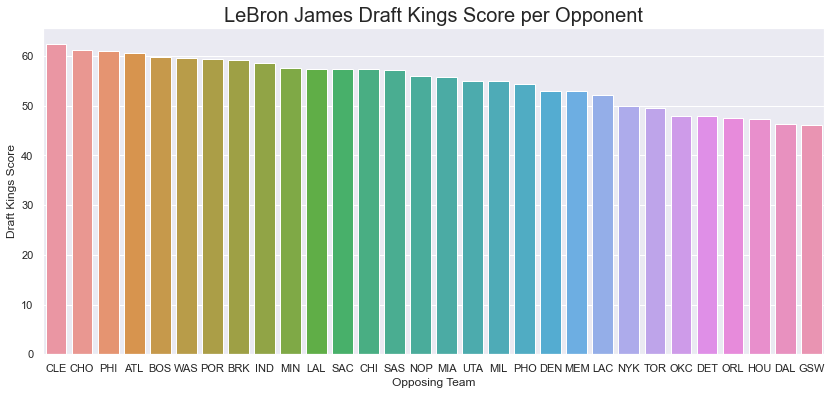

In [44]:
def plot_player_opp(player_list):
    data = nba_stats[nba_stats.Player.isin(player_list)]
    data_by_opp = data.groupby('Opp')['dk_score'].mean().reset_index().sort_values(by='dk_score',ascending=False)
    plt.figure(figsize=(14,6))
    sns.barplot(x='Opp',y='dk_score',data=data_by_opp)
    plt.xlabel('Opposing Team')
    plt.ylabel('Draft Kings Score')
    if len(player_list) >1:
        plt.title('Draft Kings Score per Opponent',fontsize=20)
    else:
        plt.title(player_list[0]+' Draft Kings Score per Opponent',fontsize=20);
    
plot_player_opp(['LeBron James'])

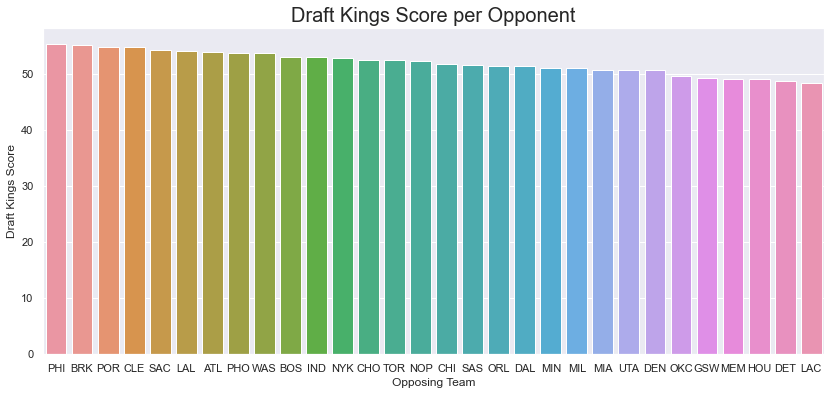

In [45]:
top_ten = ['LeBron James','Giannis Antetokounmpo','James Harden','Steph Curry','Kevin Durant',
          'Damian Lillard','Russell Westbrook','Kawhi Leonard','Joel Embiid']
plot_player_opp(top_ten)

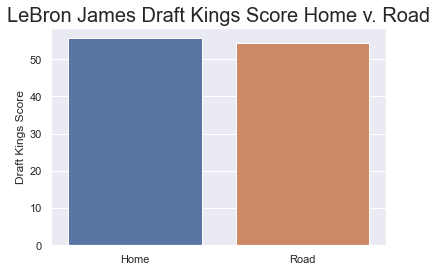

In [46]:
def plot_player_away(player_list):
    data = nba_stats[nba_stats.Player.isin(player_list)]
    data_by_away = data.groupby('Away')['dk_score'].mean().reset_index()
    data_by_away.Away = data_by_away.Away.map({0:'Home',1:'Road'})
    sns.barplot(x='Away',y='dk_score',data=data_by_away)
    plt.xlabel('')
    plt.ylabel('Draft Kings Score')
    if len(player_list) >1:
        plt.title('Draft Kings Score Home v. Road',fontsize=20)
    else:
        plt.title(player_list[0]+' Draft Kings Score Home v. Road',fontsize=20);
    
plot_player_away(['LeBron James'])

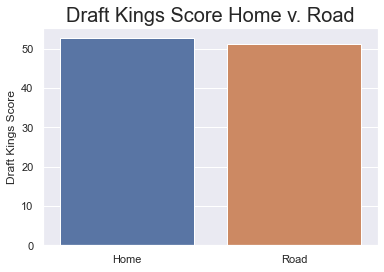

In [47]:
plot_player_away(top_ten)

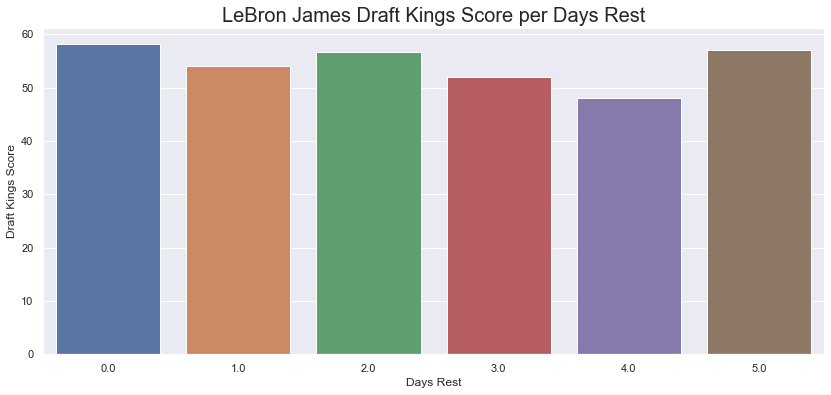

In [48]:
def plot_player_days_rest(player_list):
    data = nba_stats[nba_stats.Player.isin(player_list)]
    data_by_days_rest = data.groupby('days_rest')['dk_score'].mean().reset_index()
    plt.figure(figsize=(14,6))
    sns.barplot(x='days_rest',y='dk_score',data=data_by_days_rest)
    plt.xlabel('Days Rest')
    plt.ylabel('Draft Kings Score')
    if len(player_list) >1:
        plt.title('Draft Kings Score per Days Rest',fontsize=20)
    else:
        plt.title(player_list[0]+' Draft Kings Score per Days Rest',fontsize=20);
        
plot_player_days_rest(['LeBron James'])

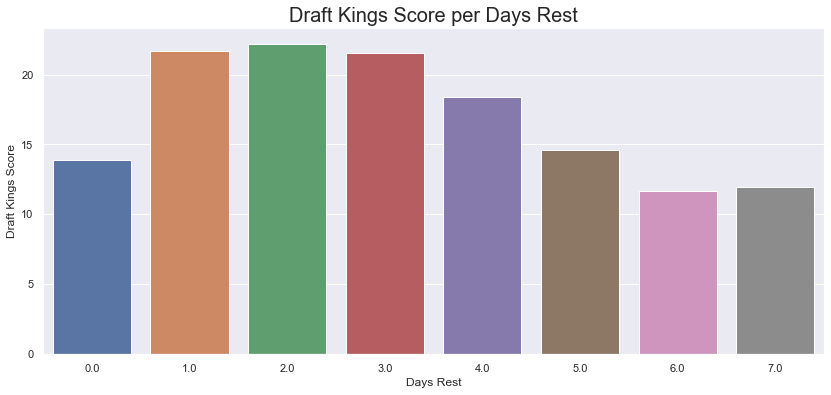

In [49]:
plot_player_days_rest(nba_stats.Player.unique())

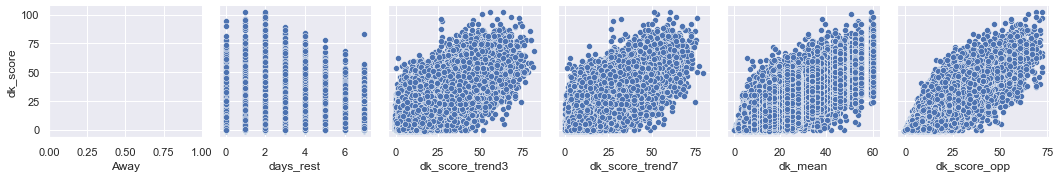

In [68]:
features = ['Away','days_rest','dk_score_trend3','dk_score_trend7','dk_mean','dk_score_opp']
sns.pairplot(nba_stats,x_vars=features,y_vars='dk_score');

In [66]:
corrs = pd.DataFrame(nba_stats.corr()['dk_score'][features].values,columns=['Draft Kings Score'],index=['Road Team','Days Rest',
                                                                                  '3 Game Trend','7 Game Trend',
                                                                                  'Season Average','Average v. Opponent'])

import plotly.figure_factory as ff
fig = ff.create_table(corrs,index=True)
fig.update_layout(autosize=False,width=500,height=200,)
fig.write_image("table_plotly.png", scale=2)
fig.show()

In [52]:
dk = nba_stats[['dk_score','Player','Date','Team','Away','Opp','days_rest','dd','td',
               'dk_score_trend3','dk_score_trend7','dk_mean','dk_score_opp']]

fd = nba_stats[['fd_score','Player','Date','Team','Away','Opp','days_rest',
               'fd_score_trend3','fd_score_trend7','fd_mean','fd_score_opp']]

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

train = dk[dk.Date.dt.year.isin([2017,2018])]
test = dk[dk.Date.dt.year==2019]

x_train = train.dk_score_trend3.values.reshape(-1,1)
x_test = test.dk_score_trend3.values.reshape(-1,1)
y_train = train.dk_score
y_test = test.dk_score

lr = LinearRegression().fit(x_train,y_train)
pred = lr.predict(x_test)
def get_metrics(pred):
    print('R squared: ',r2_score(y_test,pred))
    print('RMSE: ',np.sqrt(mean_squared_error(y_test,pred)))
    
get_metrics(pred)

R squared:  0.5163180949098314
RMSE:  10.279538794493973


In [54]:
X_train_all = train[features]
X_test_all = test[features]

lr_all = LinearRegression().fit(X_train_all,y_train)
pred_all = lr_all.predict(X_test_all)

get_metrics(pred_all)

R squared:  0.6618345882302781
RMSE:  8.595245827466565


In [55]:
dk.dk_score.describe()['std']

14.285683948081356

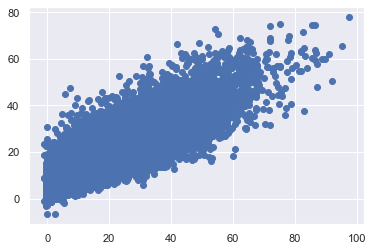

In [56]:
plt.scatter(y_test,pred_all)

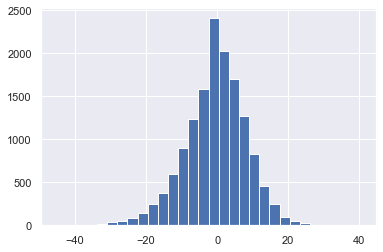

In [57]:
plt.hist(pred_all-y_test,bins=30);

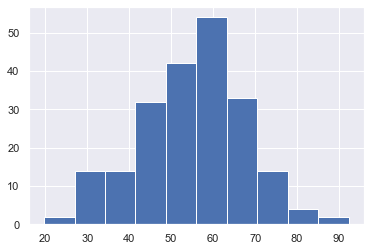

In [58]:
plt.hist(lebron.dk_score);

In [59]:
from sklearn.linear_model import LassoCV

In [60]:
lasso = LassoCV().fit(X_train_all,y_train)
lasso_pred = lasso.predict(X_test_all)
lasso_pred

array([36.77967744, 38.00496766, 34.68163454, ..., 12.7187178 ,
        8.18954992, -1.09250706])

In [61]:
get_metrics(lasso_pred)

R squared:  0.6612334918364267
RMSE:  8.602881554253521


In [62]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only=True)

X_train_poly = poly.fit_transform(X_train_all)
X_test_poly = poly.fit_transform(X_test_all)

lr_poly = LinearRegression().fit(X_train_poly,y_train)
pred_poly = lr_poly.predict(X_test_poly)

get_metrics(pred_poly)

R squared:  0.6619481925189524
RMSE:  8.59380195003788
